# Avaliação de eficiência das consultas

### Tema: Gerenciador de peladas
#### Grupo:
* Breno Poggiali de Sousa
* Gabriela Peres Neme
* Guilherme de Abreu Lima Buitrago Miranda
* Vinicius Julião Ramos 

#### Objetivo:
Cada uma das 10 consultas realizadas anteriormente podem ser formuladas de pelo menos duas formas. Nesse sentido, serão avaliadas as formas mais eficientes de realizá-las. Para isso, serão separadas três formas de avaliação principais: 
* NATURAL JOIN X JOIN ON
* NATURAL JOIN X produto cartesiano + condição WHERE
* JOIN ON X produto cartesiano + condição WHERE
* FROM A JOIN B WHERE B =... X FROM A JOIN (SELECT * FROM B WHERE B =...) 
* LIMIT(1) X MAX

#### Importação das bibliotecas e conexão ao banco de dados:

In [1]:
import io
import sqlite3
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np

conn = sqlite3.connect('BD/database.db')
cursor = conn.cursor()

In [2]:
# função que executa as consultas a partir de uma string, <num_repeticoes> vezes e apura a média das execuções
def executaComandosSQL(consulta, conn, num_repeticoes = 100):
    t=np.empty(num_repeticoes)
    for i in range(0, num_repeticoes):
        start = time.time()
        df = pd.read_sql_query(consulta, conn)
        end = time.time()
        t[i] = end - start
    
    return t.mean()
    


## Avaliação 1 - NATURAL JOIN X JOIN
Serão utilizadas as consultas 1, 2 e 4 para essa avaliação

In [3]:
t1=[]
t2=[]

#### Consulta 1

In [4]:
id_vaquinha_coletiva = 2
# Forma 1, usando NATURAL JOIN
consulta = ("SELECT nome_pessoa, valor_pago " 
            "FROM Vaquinha_Coletiva_Pessoa NATURAL JOIN Pessoa " 
             "WHERE id_vaquinha_coletiva = " + str(id_vaquinha_coletiva) + 
             " ORDER BY nome_pessoa;")

t1.append(executaComandosSQL(consulta, conn))

# Forma 2, usando JOIN ON
consulta =("SELECT nome_pessoa, valor_pago " 
             "FROM Vaquinha_Coletiva_Pessoa JOIN Pessoa ON Vaquinha_Coletiva_Pessoa.id_pessoa = Pessoa.id_pessoa " 
             "WHERE id_vaquinha_coletiva = " + str(id_vaquinha_coletiva) + " "
             "ORDER BY nome_pessoa;")

t2.append(executaComandosSQL(consulta, conn))

#### Consulta 2

In [5]:
id_pelada = 9

# Forma 1, usando NATURAL JOIN
consulta = ("SELECT nome_pessoa, Pontos, Nota, G, GC "
             "FROM Jogador NATURAL JOIN Pessoa " 
             "WHERE Jogador.id_pelada = " + str(id_pelada) + " " 
             "ORDER BY nome_pessoa;")
t1.append(executaComandosSQL(consulta, conn))

# Forma 2, usando JOIN ON
consulta = ("SELECT nome_pessoa, Pontos, Nota, G, GC " 
             "FROM Jogador JOIN Pessoa ON Jogador.id_pessoa = Pessoa.id_pessoa  " 
             "WHERE Jogador.id_pelada = " + str(id_pelada) + " " 
             "ORDER BY nome_pessoa;")

t2.append(executaComandosSQL(consulta, conn))

#### Consulta 4

In [6]:
id_grupo_de_pelada = 1 #grupo desejado
data_inicio = '2019-06-04 00:00:00' #formato AAAA-MM-DD HH:MM:SS
data_fim = '2019-12-30 00:00:00' #formato AAAA-MM-DD HH:MM:SS

# Forma 1, usando NATURAL JOIN
consulta = ("SELECT lugar, preco, inicio, fim " 
             "FROM Grupo_de_pelada NATURAL JOIN Pelada " 
             "WHERE id_grupo_de_pelada = " + str(id_grupo_de_pelada) + " AND " 
                 "(inicio BETWEEN '"+ data_inicio +"' AND '" + data_fim + "' ) " 
             "ORDER BY inicio;")
t1.append(executaComandosSQL(consulta, conn))

# Forma 2, usando JOIN ON
consulta = ("SELECT lugar, preco, inicio, fim " 
             "FROM Grupo_de_pelada JOIN Pelada ON Grupo_de_pelada.id_grupo_de_pelada = Pelada.id_grupo_de_pelada " 
             "WHERE Pelada.id_grupo_de_pelada = " + str(id_grupo_de_pelada) + " AND " 
                 "(inicio BETWEEN '"+ data_inicio +"' AND '" + data_fim + "' ) " 
             "ORDER BY inicio;")

t2.append(executaComandosSQL(consulta, conn))

### Comparação de resultados

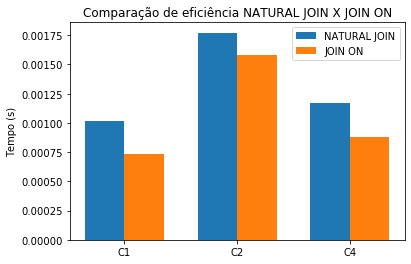

In [7]:
ind = np.arange(len(t1)) 
width = 0.35
plt.bar(ind-width/2, t1, width, label='NATURAL JOIN')
plt.bar(ind+width/2, t2, width, label='JOIN ON')
plt.ylabel('Tempo (s)')
plt.title('Comparação de eficiência NATURAL JOIN X JOIN ON')
plt.xticks(ind, ('C1', 'C2', 'C4'))
plt.legend()
plt.show()

### Conclusão análise 1
Apesar de haver variações significativas do tempo obtido a cada iteração, em todas as simulações o tempo de execução da operação NATURAL JOIN foi maior que da operação JOIN ON. Tal fato evidencia que a operação de JOIN ON é mais eficiente que a operação de NATURAL JOIN.

Uma explicação plausível para essa diferença de desempenho é que, ao utilizar NATURAL JOIN, é necessário que o SGBD realize uma busca entre os nomes das colunas, à procura daqueles que são coincidentes. Como, para a operação JOIN ON, a informação da coluna em que será feita a junção é fornecida no comando, o algoritmo de busca de colunas com nomes coincidentes não é feito, o que torna sua execução mais rápida e, consequentemente, mais eficiente.

## Avaliação 2 - NATURAL JOIN X produto cartesiano + condição WHERE
Serão utilizadas as consultas 5 e 6 para essa avaliação

In [8]:
t1.clear()
t2.clear()

#### Consulta 5

In [9]:
id_grupo_de_pelada = 1 #grupo desejado
data_inicio = '2019-06-04 00:00:00' #formato AAAA-MM-DD HH:MM:SS
data_fim = '2019-08-30 00:00:00' #formato AAAA-MM-DD HH:MM:SS

# Forma 1, usando NATURAL JOIN
consulta = ("SELECT motivo, prazo " 
             "FROM Grupo_de_pelada NATURAL JOIN Vaquinha " 
             "WHERE id_grupo_de_pelada = " + str(id_grupo_de_pelada) + " AND " 
                 "(prazo BETWEEN '"+ data_inicio +"' AND '" + data_fim + "' ) " 
             "ORDER BY prazo;")

t1.append(executaComandosSQL(consulta, conn))

# Forma 2, usando produto cartesiano + condição WHERE
consulta = ("SELECT motivo, prazo " 
             "FROM Grupo_de_pelada, Vaquinha " 
             "WHERE Grupo_de_pelada.id_grupo_de_pelada = " + str(id_grupo_de_pelada) + " AND " 
                   "(prazo BETWEEN '"+ data_inicio +"' AND '" + data_fim + "' ) AND "
                   "Vaquinha.id_grupo_de_pelada = Grupo_de_pelada.id_grupo_de_pelada "
             "ORDER BY prazo;")

t2.append(executaComandosSQL(consulta, conn))

#### Consulta 6

In [10]:
email = 'fabio@gmail.com'

# Forma 1, usando NATURAL JOIN
consulta = ("SELECT Grupo_de_pelada.nome, Grupo_de_pelada.descricao " 
             "FROM Pessoa NATURAL JOIN Participa_grupo_pelada NATURAL JOIN Grupo_de_pelada " 
             "WHERE Pessoa.email = '" + email + "';")

t1.append(executaComandosSQL(consulta, conn))

# Forma 2, usando produto cartesiano + condição WHERE
consulta = ("SELECT Grupo_de_pelada.nome, Grupo_de_pelada.descricao " 
             "FROM Pessoa, Participa_grupo_pelada, Grupo_de_pelada " 
             "WHERE Pessoa.email = '" + email + "' AND "
             "Pessoa.id_pessoa = Participa_grupo_pelada.id_pessoa AND "
             "Participa_grupo_pelada.id_grupo_de_pelada = Grupo_de_pelada.id_grupo_de_pelada;")

t2.append(executaComandosSQL(consulta, conn))

### Comparação de resultados

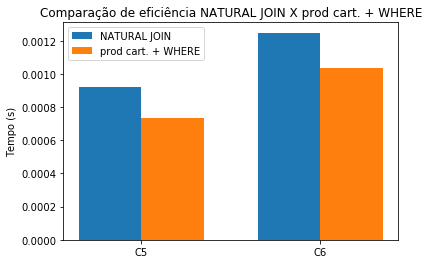

In [11]:
ind = np.arange(len(t1)) 
width = 0.35
plt.bar(ind-width/2, t1, width, label='NATURAL JOIN')
plt.bar(ind+width/2, t2, width, label='prod cart. + WHERE')
plt.ylabel('Tempo (s)')
plt.title('Comparação de eficiência NATURAL JOIN X prod cart. + WHERE')
plt.xticks(ind, ('C5', 'C6'))
plt.legend()
plt.show()

### Conclusão análise 2
/todo

## Avaliação 3 - JOIN ON X produto cartesiano + condição WHERE
Serão utilizadas as consultas 3 e 10 para essa avaliação.

In [12]:
t1.clear()
t2.clear()

#### Consulta 3

In [12]:
email = 'fabio@gmail.com'

# Forma 1, usando JOIN ON
consulta = ("SELECT Grupo_de_pelada.nome, Grupo_de_pelada.descricao " +
                         "FROM Pessoa JOIN Grupo_de_Pelada ON Pessoa.id_pessoa = Grupo_de_Pelada.id_adm " +
                         "WHERE Pessoa.email = '" + email + "';")

t1.append(executaComandosSQL(consulta, conn))

# Forma 2, usando produto cartesiano + condição WHERE
consulta = ("SELECT Grupo_de_pelada.nome, Grupo_de_pelada.descricao " 
             "FROM Pessoa, Grupo_de_Pelada " 
             "WHERE Pessoa.email = '" + email + "' AND "
                   "Pessoa.id_pessoa = Grupo_de_Pelada.id_adm ;")

t2.append(executaComandosSQL(consulta, conn))

#### Consulta 10

In [13]:
# Forma 1, usando JOIN ON
consulta = ("SELECT motivo, prazo, sum(valor_pago) as total_pago, valor_total " 
             "FROM (Vaquinha JOIN Vaquinha_Coletiva ON Vaquinha.id_vaquinha =  Vaquinha_Coletiva.id_vaquinha_coletiva) "
                 "JOIN Vaquinha_Coletiva_Pessoa ON  Vaquinha_Coletiva.id_vaquinha_coletiva = Vaquinha_Coletiva_Pessoa.id_vaquinha_coletiva "
              "GROUP BY Vaquinha_Coletiva.id_vaquinha_coletiva;")

t1.append(executaComandosSQL(consulta, conn))

# Forma 2, usando produto cartesiano + condição WHERE
consulta = ("SELECT motivo, prazo, sum(valor_pago) as total_pago, valor_total " 
             "FROM Vaquinha, Vaquinha_Coletiva , Vaquinha_Coletiva_Pessoa "
             "WHERE Vaquinha.id_vaquinha =  Vaquinha_Coletiva.id_vaquinha_coletiva AND "
                   "Vaquinha_Coletiva.id_vaquinha_coletiva = Vaquinha_Coletiva_Pessoa.id_vaquinha_coletiva "
              "GROUP BY Vaquinha_Coletiva.id_vaquinha_coletiva;")


t2.append(executaComandosSQL(consulta, conn))


### Comparação de resultados

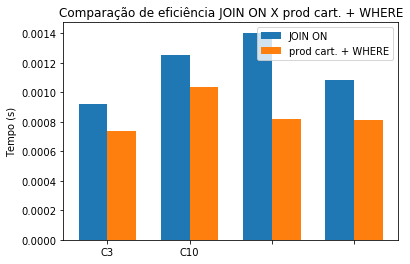

In [14]:
ind = np.arange(len(t1)) 
width = 0.35
plt.bar(ind-width/2, t1, width, label='JOIN ON')
plt.bar(ind+width/2, t2, width, label='prod cart. + WHERE')
plt.ylabel('Tempo (s)')
plt.title('Comparação de eficiência JOIN ON X prod cart. + WHERE')
plt.xticks(ind, ('C3', 'C10'))
plt.legend()
plt.show()

### Conclusão análise 3
/todo

## Avaliação 4 - FROM A JOIN B WHERE B =... X FROM A JOIN (SELECT * FROM B WHERE B =...)
Serão utilizadas as consultas 7 e 8 para essa avaliação.

In [15]:
t1.clear()
t2.clear()

#### Consulta 7

In [16]:
email = 'fabio@gmail.com'

# Forma 1, usando FROM A JOIN B WHERE B =...
consulta = ("SELECT Grupo_de_pelada.nome, Pelada.lugar, Pelada.preco, Pelada.inicio, Pontos, Nota, G, GC "
             "FROM Pessoa NATURAL JOIN Jogador NATURAL JOIN Pelada NATURAL JOIN Grupo_de_pelada "
             "WHERE Pessoa.email = '" + email + "' "
             "ORDER BY inicio desc;")

t1.append(executaComandosSQL(consulta, conn))

# Forma 2, usando FROM A JOIN (SELECT B FROM WHERE B =...)
consulta = ("SELECT Grupo_de_pelada.nome, Pelada.lugar, Pelada.preco, Pelada.inicio, Pontos, Nota, G, GC " 
             "FROM Jogador NATURAL JOIN Pelada NATURAL JOIN Grupo_de_pelada NATURAL JOIN (SELECT * FROM Pessoa " 
             "WHERE Pessoa.email = '" + email + "') "
             "ORDER BY inicio desc;")

t2.append(executaComandosSQL(consulta, conn))

#### Consulta 8

In [17]:
id_vaquinha_individual = 1

# Forma 1, usando FROM A JOIN B WHERE B =...
consulta = ("SELECT nome_pessoa, pergunta_personalizada, valor, resposta " 
             "FROM Pessoa NATURAL JOIN Vaquinha_Individual_Pessoa NATURAL JOIN Vaquinha_Individual " 
             "WHERE id_vaquinha_individual = " + str(id_vaquinha_individual) + " " 
             "ORDER BY nome_pessoa;")

t1.append(executaComandosSQL(consulta, conn))

# Forma 2, usando FROM A JOIN (SELECT B FROM WHERE B =...)
consulta = ("SELECT nome_pessoa, pergunta_personalizada, valor, resposta " 
             "FROM Pessoa NATURAL JOIN Vaquinha_Individual_Pessoa NATURAL JOIN (SELECT * FROM Vaquinha_Individual " 
             "WHERE id_vaquinha_individual = " + str(id_vaquinha_individual) + ") " 
             "ORDER BY nome_pessoa;")

t2.append(executaComandosSQL(consulta, conn))

### Comparação de resultados

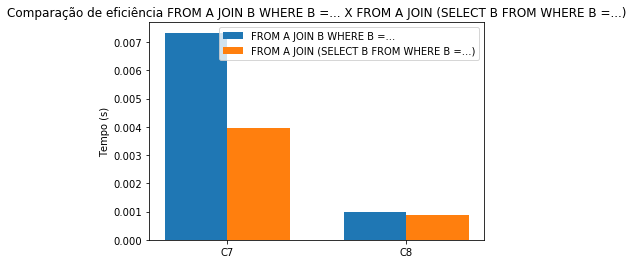

In [18]:
ind = np.arange(len(t1)) 
width = 0.35
plt.bar(ind-width/2, t1, width, label='FROM A JOIN B WHERE B =...')
plt.bar(ind+width/2, t2, width, label='FROM A JOIN (SELECT B FROM WHERE B =...)')
plt.ylabel('Tempo (s)')
plt.title('Comparação de eficiência FROM A JOIN B WHERE B =... X FROM A JOIN (SELECT B FROM WHERE B =...)')
plt.xticks(ind, ('C7', 'C8'))
plt.legend()
plt.show()

### Conclusão análise 4
/todo

## Avaliação 5 - LIMIT(1) x MAX()
Será utilizada a consulta 9 para essa avaliação.

In [37]:
t1.clear()
t2.clear()

#### Consulta 9

In [38]:
email = 'luan@gmail.com'

# Forma 1, usando LIMIT(1)
consulta = ("SELECT Grupo_de_Pelada.nome, lugar, inicio, sum(G) as Gols_na_partida  "
             "FROM Jogador NATURAL JOIN Pelada NATURAL JOIN Grupo_de_Pelada " 
             "WHERE id_pelada in (SELECT id_pelada FROM Jogador NATURAL JOIN Pessoa WHERE email = '" + email + "') " 
             "GROUP BY id_pelada " 
             "ORDER BY Gols_na_partida desc limit(1);")

t1.append(executaComandosSQL(consulta, conn))

# Forma 2, usando MAX()

consulta = ("SELECT  nome, lugar, inicio, MAX(Gols_na_partida) FROM ("
            "SELECT Grupo_de_Pelada.nome, lugar, inicio, sum(G) as Gols_na_partida  "
             "FROM Jogador NATURAL JOIN Pelada NATURAL JOIN Grupo_de_Pelada " 
             "WHERE id_pelada in (SELECT id_pelada FROM Jogador NATURAL JOIN Pessoa WHERE email = '" + email + "') " 
             "GROUP BY id_pelada);")

t2.append(executaComandosSQL(consulta, conn))

### Comparação de resultados

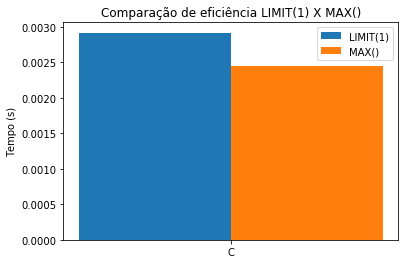

In [39]:
ind = np.arange(len(t1)) 
width = 0.35
plt.bar(ind-width/2, t1, width, label='LIMIT(1)')
plt.bar(ind+width/2, t2, width, label='MAX()')
plt.ylabel('Tempo (s)')
plt.title('Comparação de eficiência LIMIT(1) X MAX()')
plt.xticks(ind, ('C9'))
plt.legend()
plt.show()

### Conclusão análise 4
/todo